In [310]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression as LinearRegression
from scipy.interpolate import interp1d
# Add the src directory t\ the Python path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Now you can import the TimeSeriesDataset class
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.utils import download_data, weighted_mean
from src.mappings import value_mapping, ideology_mapping, social_complexity_mapping

In [312]:
use_resid = True

if use_resid:
    # Load the residuals
    dataset_filename = '../datasets/power_transitions_with_residuals.xlsx'
else:
    dataset_filename = '../datasets/power_transitions.xlsx'

polity_df = download_data("https://seshatdata.com/api/core/polities/")
dataset = TSD(file_path=dataset_filename)
dataset.scv = dataset.scv.groupby('dataset').get_group('100y')
dataset.scv_imputed = dataset.scv_imputed.groupby('dataset').get_group('100y')

Downloaded 839 rows
Dataset loaded from ../datasets\power_transitions_with_residuals.xlsx


import Agri and AgriLag from TableData

In [313]:
import pyreadr

data = pyreadr.read_r("../datasets/TableData.Rdata")
df = data['ImpSCDat']
df_agri = data['AggrSCWarAgriRelig']

add_cols = ['Metal','Project','Weapon','Animal','Armor','Defense','Cavalry','Iron','Agri','AgriLag']
for col in add_cols:
    df[col] = df_agri[col]

col_replacements = {'Time': 'Year', 'Hier':'Hierarchy', 'Gov':'Government', 'Infra':'Infrastructure',
                    'Info': 'Information'}
df = df.rename(columns=col_replacements)
df['PolityName'] = df['PolID'].apply(lambda x: polity_df.loc[polity_df['name'] == x, 'new_name'].values[0] if x in polity_df['name'].values else np.nan)
df['PolityID'] = df['PolID'].apply(lambda x: polity_df.loc[polity_df['name'] == x, 'id'].values[0] if x in polity_df['name'].values else np.nan)
df.drop_duplicates(subset=['PolityName', 'Year'], inplace=True)

df_old = df.copy()

In [314]:
if 'Agri' not in dataset.scv.columns:
    add_cols = ['Agri','AgriLag']
    for col in add_cols:
        dataset.scv[col] = np.nan
    # add cols to dataset by merging on PolityID and year from df_agri
    for n, row in df.iterrows():
        for col in add_cols:
            dataset.scv.loc[(dataset.scv['PolityName'] == row['PolityName']) & (dataset.scv['Year'] == row['Year']), col] = row[col]
            if len(dataset.scv.loc[(dataset.scv['PolityName'] == row['PolityName']) & (dataset.scv['Year'] == row['Year'])]) > 1:
                print(row['PolityName'], row['Year'])
                
    # fill in missing values for Agri and AgriLag when a polity has only some years missing
    for pol in dataset.scv.PolityName.unique(): 
        for col in add_cols:
            if dataset.scv.loc[dataset.scv['PolityName'] == pol, col].isna().any() and dataset.scv.loc[dataset.scv['PolityName'] == pol, col].notna().any():
                if col == 'Agri':
                    dataset.scv.loc[dataset.scv['PolityName'] == pol, col] = dataset.scv.loc[dataset.scv['PolityName'] == pol, col].fillna(method='ffill')
                elif col == 'AgriLag':
                    # calculate change in year and add to agrilag value
                    agrilag = dataset.scv.loc[(dataset.scv['PolityName'] == pol)&(dataset.scv["AgriLag"].notna()), col].iloc[0]
                    year = dataset.scv.loc[(dataset.scv['PolityName'] == pol)&(dataset.scv["AgriLag"].notna()), 'Year'].iloc[0]
                    year_diff = year - dataset.scv.loc[(dataset.scv['PolityName'] == pol), 'Year']
                    dataset.scv.loc[dataset.scv['PolityName'] == pol, col] = dataset.scv.loc[dataset.scv['PolityName'] == pol, col].fillna(agrilag - year_diff)

transfer_cols = ['Agri','AgriLag']
for col in transfer_cols:
    dataset.scv_imputed[col] = dataset.scv[col]

plot new (imputed) data against Tabledata

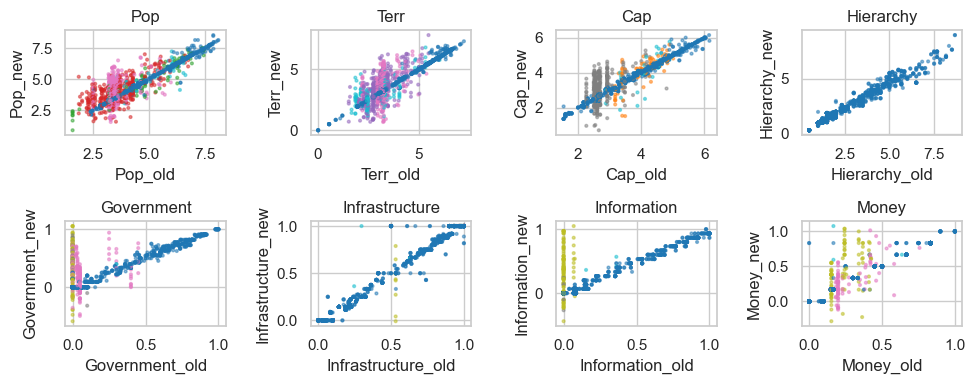

In [315]:
fig, ax = plt.subplots(2, 4, figsize=(10, 4))
ax = ax.flatten()
scale_cols = ['Pop','Terr','Cap']
non_scale_cols = ['Government','Infrastructure','Information','Money']
for c,col in enumerate(scale_cols+['Hierarchy']+non_scale_cols):
    dataset.scv_imputed["color"] = dataset.scv_imputed.fit.apply(lambda x: eval(x)[list(dataset.scv.columns).index(col)])
    df_merge = df[['PolityName','Year',col]].merge(dataset.scv_imputed[['PolityName','Year',col, "color"]], on=['PolityName','Year'], suffixes=('_old','_new'))
    df_merge['diff'] = df_merge[col+'_old'] - df_merge[col+'_new']
    df_merge['diff'] = df_merge['diff'].abs()
    df_merge = df_merge.sort_values('diff', ascending=False)

    ax[c].scatter(df_merge[col+'_old'], df_merge[col+'_new'], c = df_merge.color, cmap="tab10", alpha=0.5, s = 4)
    # df_merge = df[['PolityName','Year',col]].merge(dataset.scv[['PolityName','Year',col]], on=['PolityName','Year'], suffixes=('_old','_new'))
    # ax[c].plot(df_merge[col+'_old'], df_merge[col+'_new'], '.', color ="goldenrod", alpha=0.5, markersize = 4)

    ax[c].set_ylabel(col+'_new')
    ax[c].set_xlabel(col+'_old')
    ax[c].set_title(col)
plt.tight_layout()
plt.show()

In [316]:
def autocorr(self: np.ndarray, lag=1):
    """
    Lag-N autocorrelation

    Parameters
    ----------
    self : numpy.ndarray
        Input array for which autocorrelation is calculated.
    lag : int, default 1
        Number of lags to apply before performing autocorrelation.

    Returns
    -------
    autocorr : float
    """
    return np.corrcoef(self[:-lag], self[lag:])[0, 1] if lag < len(self) else np.nan

def crosscorr(datax: np.ndarray, datay: np.ndarray, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : numpy.ndarray objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    if len(datax) != len(datay):
        raise ValueError("Input arrays must have the same length.")
    if lag < 0:
        datax, datay = datay, datax
        lag = -lag
    elif lag == 0:
        return np.corrcoef(datax, datay)[0, 1]
    try:
        return np.corrcoef(datax[:-lag], datay[lag:])[0, 1] if lag < len(datax) else np.nan
    except ValueError:
        # Handle the case where the arrays are too short for the lag
        return np.nan

def get_correlations(datax,datay):
    correlations = [np.nan for i in range(0, 100)]
    corr_length = min(len(datax)-20, 20)
    lags = np.arange(-corr_length, corr_length)
    for i,lag in enumerate(lags):
        correlations[i] = crosscorr(datax, datay, lag=lag)
    # shift correlations to center around 25
    correlations = np.roll(correlations, 20-corr_length)
    return correlations

def impute_missing_values(df, col1, col2):
    years = df['Year'].unique()
    all_years = np.arange(years.min(), years.max() +1, 100)

    df_col1 = df[[ 'Year', col1]].copy().dropna()
    imputed_col1 = interp1d(df_col1['Year'], df_col1[col1], kind='linear', fill_value='extrapolate')(all_years)
    df_col2 = df[[ 'Year', col2]].copy().dropna()
    imputed_col2 = interp1d(df_col2['Year'], df_col2[col2], kind='linear', fill_value='extrapolate')(all_years)

    return imputed_col1, imputed_col2

def get_av_correlation(lags, all_correlations):
    av_corr = np.zeros(len(lags))
    av_se = np.zeros(len(lags))
    for i in range(len(lags)):
        row = np.array(all_correlations)[:,i]
        # remove nans
        row = row[~np.isnan(row)]
        av_corr[i] = np.mean(row)
        av_se[i] = np.std(row) / np.sqrt(len(row))
    return av_corr, av_se

ValueError for nan - skipping


c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: inva

ValueError for nan - skipping
ValueError for Ghanaian Coast - skipping
ValueError for Chuuk Islands - skipping


c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: inva

ValueError for Southern China Hills - skipping
ValueError for nan - skipping
ValueError for Southern China Hills - skipping
ValueError for nan - skipping
ValueError for Ghanaian Coast - skipping


c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: inva

ValueError for Southern China Hills - skipping
ValueError for nan - skipping
ValueError for nan - skipping


c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: inva

ValueError for nan - skipping
ValueError for Ghanaian Coast - skipping
ValueError for Chuuk Islands - skipping


c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: inva

ValueError for Southern China Hills - skipping
ValueError for nan - skipping
ValueError for Southern China Hills - skipping
ValueError for nan - skipping
ValueError for Ghanaian Coast - skipping


c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: inva

ValueError for Southern China Hills - skipping
ValueError for nan - skipping


Text(0.5, 1.02, 'Comp and Scale cross-correlations')

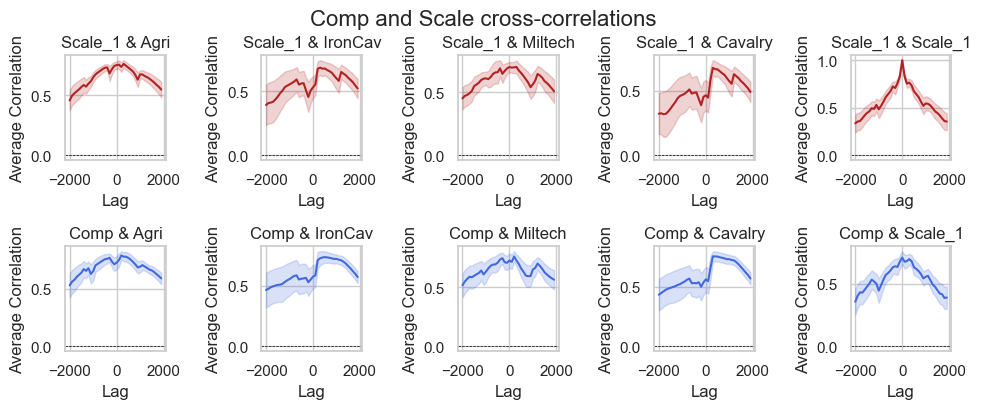

In [317]:
ref_cols = ["Scale_1","Comp"]
pred_cols = ["Agri", "IronCav", "Miltech", "Cavalry","Scale_1"]
colors = ["firebrick", "royalblue"]
fig, ax = plt.subplots(len(ref_cols), len(pred_cols), figsize=(10, 4))

for i, col1 in enumerate(ref_cols):
    for j, col2 in enumerate(pred_cols):
        lags = np.arange(-20, 20)
        all_correlations = []
        for n,nga in enumerate(dataset.scv_imputed.NGA.unique()):
            df_nga = dataset.scv_imputed.loc[dataset.scv_imputed.NGA == nga]
            try:
                all_imputed_c1, all_imputed_c2 = impute_missing_values(df_nga, col1, col2)
            except ValueError:
                print(f"ValueError for {nga} - skipping")
                continue
            all_correlations.append(get_correlations(all_imputed_c2, all_imputed_c1))

        av_corr, av_se = get_av_correlation(lags, all_correlations)
        # plot
        ax[i,j].plot(lags*100, av_corr, label='Average Correlation', color=colors[i])
        ax[i,j].fill_between(lags*100, av_corr - av_se, av_corr + av_se, color= colors[i], alpha=0.2, label='Standard Error')
        ax[i,j].axhline(0, color='black', linestyle='--', linewidth=0.5)
        ax[i,j].set_xlabel('Lag')
        ax[i,j].set_ylabel('Average Correlation')
        ax[i,j].set_title(f'{col1} & {col2}')
plt.tight_layout()
plt.suptitle("Comp and Scale cross-correlations", fontsize=16, y=1.02)

In [318]:
av_corr = np.zeros(len(lags))
av_se = np.zeros(len(lags))
for i in range(len(lags)):
    row = np.array(all_correlations)[:,i]
    # remove nans
    row = row[~np.isnan(row)]
    av_corr[i] = np.mean(row)
    av_se[i] = np.std(row) / np.sqrt(len(row))

Extract next Scale and Comp values

In [319]:
dr = dataset.scv_imputed.copy()
# remove rows without NGA value
dr = dr.dropna(subset=['NGA'])
dr['Scale_t'] = np.nan
dr['d_Scale'] = np.nan
dr['Comp_t'] = np.nan
dr['d_Comp'] = np.nan


dr_nga = dr.groupby('NGA')
for nga, group in dr_nga:
    group = group.sort_values(['Year', 'PolityID'])
    group.drop_duplicates(subset = ['Year'], keep = 'first', inplace = True)

    # find values 100 years later
    dr.loc[group.index, 'Scale_t'] = group['Scale_1'].shift(-1).values
    dr.loc[group.index, 'Comp_t'] = group['Comp'].shift(-1).values
    dr.loc[group.index, 'd_Scale'] = dr.loc[group.index, 'Scale_t'] - group['Scale_1']
    dr.loc[group.index, 'd_Comp'] = dr.loc[group.index, 'Comp_t'] - group['Comp']
    
    # remove rows without a value 100 yrs later
    mask = (group['Year'].shift(-1) - group['Year'] != 100)
    indices = group.index.intersection(mask[mask].index)
    if len(indices) > 2:
        print(len(indices)-1)

    dr.loc[indices,'Scale_t'] = np.nan
    dr.loc[indices,'Comp_t'] = np.nan
    dr.loc[indices,'d_Scale'] = np.nan
    dr.loc[indices,'d_Comp'] = np.nan


2
2
2
3
6
3
2
3


Fit Scale

In [320]:
x_cols = ['Scale_1','Miltech', 'Comp']
y_col = ['Scale_t']
Xy = dr
Xy['Scale_sq'] = Xy['Scale_1']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
X.drop(columns=['Comp'], inplace=True)
y = Xy[y_col]

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Scale_t   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     2925.
Date:                Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:53:24   Log-Likelihood:                -1027.5
No. Observations:                1088   AIC:                             2061.
Df Residuals:                    1085   BIC:                             2076.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1        0.8216      0.017     47.949      0.0

C:\Users\matil\AppData\Local\Temp\ipykernel_25364\932527575.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['Comp'], inplace=True)


In [321]:
def analyze_residuals(values, residuals, bins):
    """
    Analyze residuals by binning comp values and calculating statistics
    
    Args:
        comp_values (array-like): Competitiveness values
        residuals (array-like): Model residuals
        bin_size (float): Size of bins (default 0.1)
    
    Returns:
        pandas.DataFrame with columns: Value, mean, SE, n, lower, upper
    """
    import pandas as pd
    import numpy as np

    bin_size = bins[1] - bins[0]
    # Initialize results
    results = []
    
    # Calculate stats for each bin
    for bin_center in bins[:-1]:
        mask = ((values >= bin_center - bin_size) & 
                (values < bin_center + bin_size))
        bin_residuals = residuals[mask]
        
        if len(bin_residuals) > 0:
            mean = np.mean(bin_residuals)
            se = np.std(bin_residuals)/np.sqrt(len(bin_residuals))
            results.append({
                'Value': bin_center + bin_size/2,
                'mean': mean,
                'SE': se,
                'n': len(bin_residuals),
                'lower': mean - se,
                'upper': mean + se
            })
    
    # Convert to dataframe
    df = pd.DataFrame(results)
    return df

Text(0, 0.5, 'Scale')

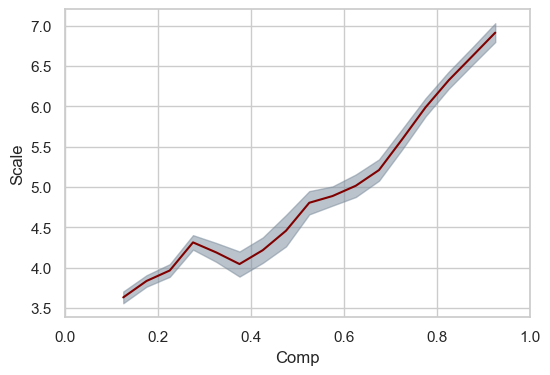

In [322]:
bins = np.arange(0.1, 1, 0.05)
results = analyze_residuals(Xy['Comp'].values, Xy['Scale_t'].values, bins)

plt.figure(figsize=(6, 4))
# plt.scatter(Xy['Comp'].values, Xy['Scale_1'].values, color='k', alpha=0.2, label='Predictions', s=3)

plt.plot(results['Value'], results['mean'], color='maroon')
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightslategray', alpha=0.5)

plt.xlim(.0, 1)
plt.xlabel("Comp")
plt.ylabel("Scale")

(0.0, 0.95)

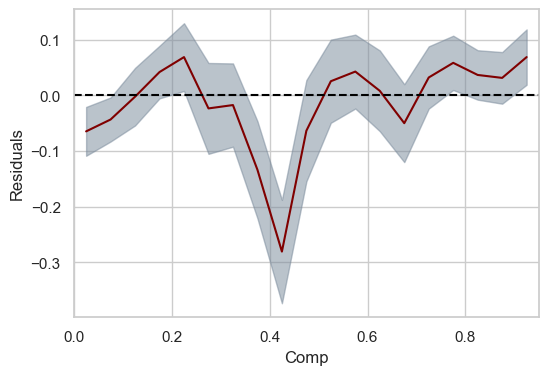

In [323]:
residuals = y['Scale_t'] - predictions.values
comp_values = Xy['Comp'].values
bins = np.arange(0., 1, 0.05)
results = analyze_residuals(comp_values, residuals, bins)
results_before = results.copy() 
residuals_before = residuals.copy()

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results['Value'], results['mean'], color='maroon')
# plot confidence intervals
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightslategray', alpha=0.5)
# plot zero line
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Comp')
plt.ylabel('Residuals')
x = np.linspace (-2,12,100)
# plt.scatter(Xy['Comp'], residuals, color='k', alpha=0.2, label='Predictions', s=3)

plt.xlim(0.0, 0.95)

In [324]:
thresh_start = np.arange(0.1, 0.9 , 0.02)
thresh_end = np.arange(0.2, 0.9, 0.01)
# x_cols = ['Scale_1','Scale_sq','Agri','AgriLag','Miltech','IronCav','Comp']
y_col = ['Scale_t']
Xy = dr
Xy['Scale_sq'] = Xy['Scale_1']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col]

results = pd.DataFrame(columns=['thresh_start', 'thresh_end', 'n', 'R2', 'R2_adj', 'AIC', 'p', 'log-likelyhood','minres',"comp_pval"])

for thresh_s in thresh_start:
    for thresh_e in thresh_end:
        mask = (Xy.Comp >= thresh_s)&(Xy.Comp <= thresh_e)
        X['Comp'] = 0
        X.loc[mask, 'Comp'] = 1

        model = sm.OLS(y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        # save results
        results = results.append({
            'thresh_start': thresh_s,
            'thresh_end': thresh_e,
            'n': len(y),
            'R2': model.rsquared,
            'R2_adj': model.rsquared_adj,
            'AIC': model.aic,
            'p': model.f_pvalue,
            'log-likelyhood': model.llf,
            'minres': np.mean(np.abs(y['Scale_t'].values - predictions)),
            'comp_pval': model.pvalues['Comp']
        }, ignore_index=True)



C:\Users\matil\AppData\Local\Temp\ipykernel_25364\1031070540.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Comp'] = 0
C:\Users\matil\AppData\Local\Temp\ipykernel_25364\1031070540.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
C:\Users\matil\AppData\Local\Temp\ipykernel_25364\1031070540.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Comp'] = 0
C:\Users\matil\AppData\Loc

In [325]:
results.sort_values('AIC', ascending=True).head(10)

thresh_start  thresh_end       n        R2    R2_adj          AIC    p  \
866          0.34        0.46  1088.0  0.844918  0.844489  2053.431971  0.0   
867          0.34        0.47  1088.0  0.844845  0.844415  2053.944572  0.0   
865          0.34        0.45  1088.0  0.844812  0.844383  2054.172845  0.0   
936          0.36        0.46  1088.0  0.844680  0.844250  2055.103030  0.0   
864          0.34        0.44  1088.0  0.844663  0.844233  2055.220606  0.0   
863          0.34        0.43  1088.0  0.844622  0.844192  2055.504437  0.0   
937          0.36        0.47  1088.0  0.844612  0.844182  2055.573355  0.0   
862          0.34        0.42  1088.0  0.844578  0.844148  2055.810595  0.0   
935          0.36        0.45  1088.0  0.844575  0.844145  2055.831491  0.0   
859          0.34        0.39  1088.0  0.844555  0.844125  2055.976640  0.0   

     log-likelyhood    minres  comp_pval  
866    -1022.715986  0.449741   0.002016  
867    -1022.972286  0.450053   0.002663  
865    -1023.086423  0.449839   0.003016  
936    -1023.551515  0.449806   0.005023  
864    -1023.610303  0.449717   0.005359  
863    -1023.752219  0.450299   0.006269  
937    -1023.786677  0.450137   0.006512  
862    -1023.905298  0.450483   0.007428  
935    -1023.915745  0.449901   0.007514  
859    -1023.988320  0.449781   0.008146

In [326]:
thresh_min = results.sort_values('AIC', ascending=True)[['thresh_start','thresh_end']].iloc[0].values
thresh_min =[0.16, 0.25]
mask = (Xy.Comp >= thresh_min[0])&(Xy.Comp <= thresh_min[1])
X['Comp'] = 0
X.loc[mask, 'Comp'] = 1

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Scale_t   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     1950.
Date:                Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:53:44   Log-Likelihood:                -1027.0
No. Observations:                1088   AIC:                             2062.
Df Residuals:                    1084   BIC:                             2082.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1        0.8198      0.017     47.598      0.0

C:\Users\matil\AppData\Local\Temp\ipykernel_25364\2940136782.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Comp'] = 0


Text(0.5, 1.0, 'Residuals with and without thresholds model')

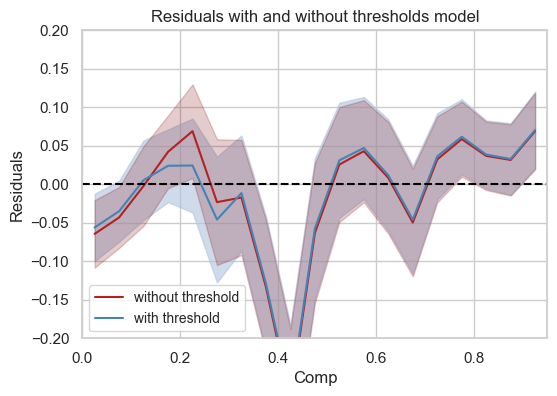

In [327]:
residuals = y['Scale_t'].values - predictions
comp_values = Xy['Comp'].values
bins = np.arange(0., 1, 0.05)
results = analyze_residuals(comp_values, residuals, bins)

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results_before['Value'], results_before['mean'], color='firebrick', label = 'without threshold')
plt.plot(results['Value'], results['mean'], color='steelblue', label = 'with threshold')
# plt.plot(results_before['Value'], results_before['mean'], color='blue')
# plot confidence intervals
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightsteelblue', alpha=0.6)
plt.fill_between(results_before['Value'], results_before['lower'], results_before['upper'], color='maroon', alpha=0.2)

plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Comp')
plt.ylabel('Residuals')
plt.legend(loc = 'lower left', fontsize = 'small')
plt.xlim(0.0, 0.95)
plt.ylim(-0.2, 0.2)
#  add grid
plt.grid(True)
plt.title('Residuals with and without thresholds model')

In [328]:
x_cols = ['Comp','Agri','Miltech','Comp_sq','Scale_1']
y_col = ['Comp_t']
Xy = dr
Xy['Comp_sq'] = Xy['Comp']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
X.drop(columns=['Scale_1'], inplace=True)
y = Xy[y_col]

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 Comp_t   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     2975.
Date:                Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:53:44   Log-Likelihood:                 1042.5
No. Observations:                1072   AIC:                            -2075.
Df Residuals:                    1067   BIC:                            -2050.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Comp           0.9477      0.037     25.684      0.0

C:\Users\matil\AppData\Local\Temp\ipykernel_25364\1677285777.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['Scale_1'], inplace=True)


(2.0, 8.5)

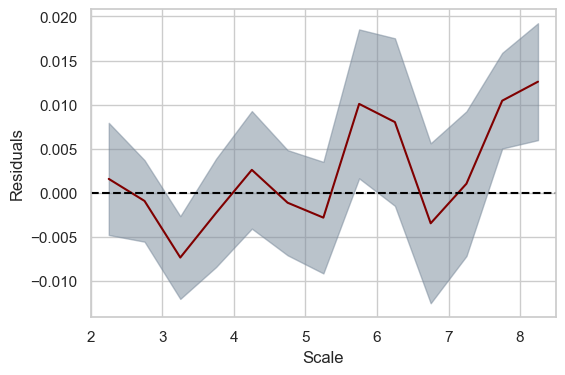

In [329]:
residuals = (y['Comp_t'].values - predictions)
scale_values = Xy['Scale_1'].values
bins = np.arange(2, 9, 0.5)

results = analyze_residuals(scale_values, residuals, bins)
results_before = results.copy()

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results['Value'], results['mean'], color='maroon')
# plot confidence intervals
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightslategray', alpha=0.5)
# plot zero line
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Scale')
plt.ylabel('Residuals')
plt.xlim(2, 8.5)

In [330]:
thresh_start = np.arange(2, 8 , 0.1)
thresh_end = np.arange(6, 10, 0.1)
x_cols = ['Scale_1','Comp_sq','Agri','AgriLag','IronCav','Comp']
y_col = ['Comp_t']
Xy = dr
Xy['Comp_sq'] = Xy['Comp']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col]

results = pd.DataFrame(columns=['thresh_start', 'thresh_end', 'n', 'R2', 'R2_adj', 'AIC', 'p','log-likelyhood','minres'])

for thresh_s in thresh_start:
    for thresh_e in thresh_end:
        mask = (Xy.Comp > thresh_s) & (Xy.Comp < thresh_e)
        X['Scale_1'] = 0
        X.loc[mask, 'Scale_1'] = 1

        model = sm.OLS(y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        # save results
        results = results.append({
            'thresh_start': thresh_s,
            'thresh_end': thresh_e,
            'n': len(y),
            'R2': model.rsquared,
            'R2_adj': model.rsquared_adj,
            'AIC': model.aic,
            'p': model.f_pvalue,
            'log-likelyhood': model.llf,
            'minres': np.mean(np.abs(y['Comp_t'].values - predictions))
        }, ignore_index=True)


C:\Users\matil\AppData\Local\Temp\ipykernel_25364\971872464.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Scale_1'] = 0
C:\Users\matil\AppData\Local\Temp\ipykernel_25364\971872464.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
C:\Users\matil\AppData\Local\Temp\ipykernel_25364\971872464.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Scale_1'] = 0
C:\Users\matil\AppData\

In [331]:
results.sort_values('AIC', ascending=True).head(10)

thresh_start  thresh_end       n        R2    R2_adj         AIC    p  \
0              2.0         6.0  1019.0  0.923574  0.923197 -2018.76151  0.0   
1596           5.9         9.6  1019.0  0.923574  0.923197 -2018.76151  0.0   
1597           5.9         9.7  1019.0  0.923574  0.923197 -2018.76151  0.0   
1598           5.9         9.8  1019.0  0.923574  0.923197 -2018.76151  0.0   
1599           5.9         9.9  1019.0  0.923574  0.923197 -2018.76151  0.0   
1600           6.0         6.0  1019.0  0.923574  0.923197 -2018.76151  0.0   
1601           6.0         6.1  1019.0  0.923574  0.923197 -2018.76151  0.0   
1595           5.9         9.5  1019.0  0.923574  0.923197 -2018.76151  0.0   
1602           6.0         6.2  1019.0  0.923574  0.923197 -2018.76151  0.0   
1604           6.0         6.4  1019.0  0.923574  0.923197 -2018.76151  0.0   

      log-likelyhood    minres  
0        1015.380755  0.051359  
1596     1015.380755  0.051359  
1597     1015.380755  0.051359  
1598     1015.380755  0.051359  
1599     1015.380755  0.051359  
1600     1015.380755  0.051359  
1601     1015.380755  0.051359  
1595     1015.380755  0.051359  
1602     1015.380755  0.051359  
1604     1015.380755  0.051359

In [332]:
thresh_min = results.sort_values('minres', ascending=True)[['thresh_start','thresh_end']].iloc[1].values
thresh_min =[5.5,6.5]

mask = (Xy.Scale_1 >= thresh_min[0]) & (Xy.Scale_1 < thresh_min[1])
X['Scale_1'] = 0
X.loc[mask, 'Scale_1'] = 1

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Comp_t   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     2041.
Date:                Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:53:59   Log-Likelihood:                 1015.9
No. Observations:                1019   AIC:                            -2018.
Df Residuals:                    1012   BIC:                            -1983.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1        0.0095      0.009      1.054      0.2

C:\Users\matil\AppData\Local\Temp\ipykernel_25364\2520104183.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Scale_1'] = 0


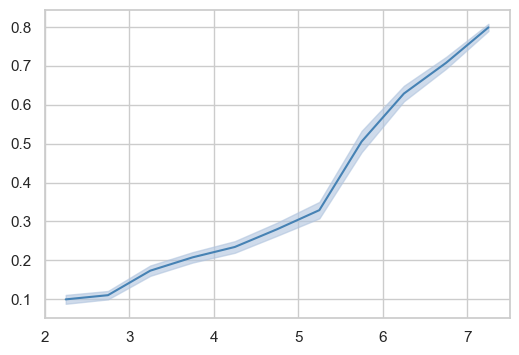

In [333]:
residuals = (y['Comp_t'].values - predictions)
scale_values = Xy['Scale_1'].values
bins = np.arange(2, 8, 0.5)
results = analyze_residuals(scale_values, y['Comp_t'].values, bins)

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results['Value'], results['mean'], color='steelblue', label = 'with threshold')
# plt.plot(results_before['Value'], results_before['mean'], color='blue')
# plot confidence intervals
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightsteelblue', alpha=0.6)


Text(0.5, 1.0, 'Residuals with and without thresholds model')

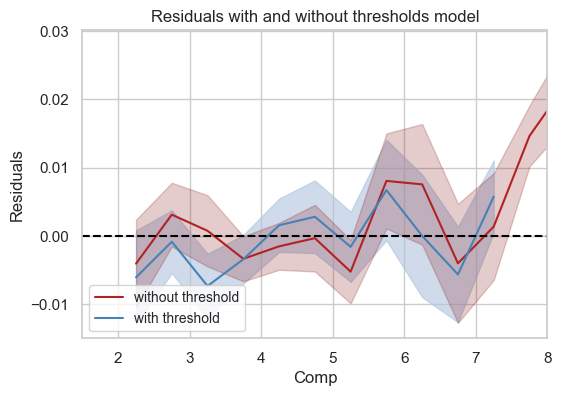

In [309]:
residuals = (y['Comp_t'].values - predictions)
scale_values = Xy['Scale_1'].values
bins = np.arange(2, 8, 0.5)
results = analyze_residuals(scale_values, residuals, bins)

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results_before['Value'], results_before['mean'], color='firebrick', label = 'without threshold')
plt.plot(results['Value'], results['mean'], color='steelblue', label = 'with threshold')
# plt.plot(results_before['Value'], results_before['mean'], color='blue')
# plot confidence intervals
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightsteelblue', alpha=0.6)
plt.fill_between(results_before['Value'], results_before['lower'], results_before['upper'], color='maroon', alpha=0.2)

plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Comp')
plt.ylabel('Residuals')
plt.legend(loc = 'lower left', fontsize = 'small')
plt.xlim(1.5, 8)
#  add grid
plt.grid(True)
plt.title('Residuals with and without thresholds model')

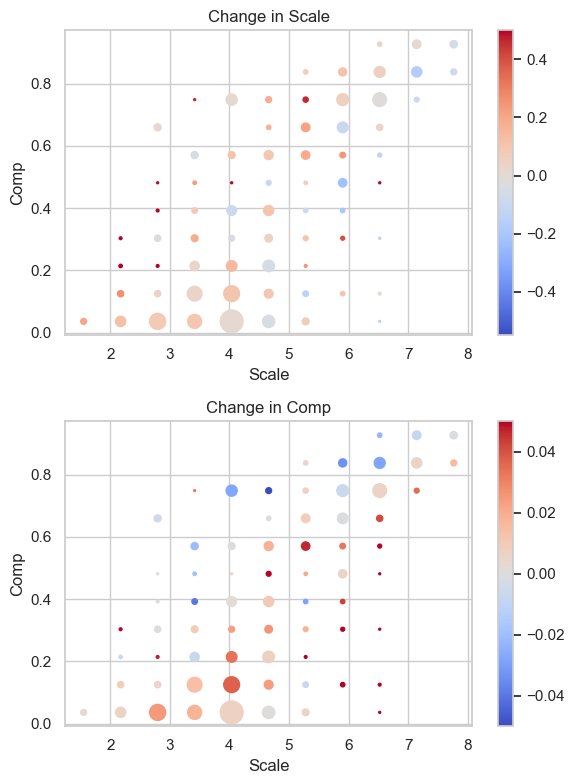

In [24]:
fig, ax = plt.subplots(2,1,figsize=(6, 8))

x_cols = ['Scale_1','Comp']
y_col = ['d_Scale','d_Comp']
Xy = dr[y_col+x_cols].dropna()

x = Xy["Scale_1"].values
y = Xy["Comp"].values
z1 = Xy["d_Scale"].values
z2 = Xy["d_Comp"].values

grid_size = 11

df = pd.DataFrame({'x': x, 'y': y, 'z1': z1, 'z2': z2}) 

# Define the grid
x_bins = np.linspace(min(x), max(x), grid_size + 1)
y_bins = np.linspace(min(y), max(y), grid_size + 1)

# Bin the data
df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)
df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)


x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

# Group by the bins and calculate the mean of z
grid_1 = df.groupby(['y_bin', 'x_bin'])['z1'].mean().unstack()
grid_1_std = df.groupby(['y_bin', 'x_bin'])['z1'].std().unstack()
counts_1 = df.groupby(['y_bin', 'x_bin'])['z1'].count().unstack()

grid_2 = df.groupby(['y_bin', 'x_bin'])['z2'].mean().unstack()
grid_2_std = df.groupby(['y_bin', 'x_bin'])['z2'].std().unstack()
counts_2 = df.groupby(['y_bin', 'x_bin'])['z2'].count().unstack()

# remove entries in grid that are not statistically significant
# grid_1[grid_1_std/2 > np.abs(grid_1)] = np.nan
# grid_2[grid_2_std/2 > np.abs(grid_2)] = np.nan

# -------------------------------- AXIS 1 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[0].scatter(x.flatten(), y.flatten(), c=grid_1.values.flatten(), cmap='coolwarm', s=counts_1.values.flatten()*2, vmax = -0.5, vmin = 0.5)
cbar = plt.colorbar(ax[0].collections[0], ax=ax[0])
ax[0].set_title('Change in Scale')
ax[0].set_ylabel('Comp')
ax[0].set_xlabel('Scale')

# -------------------------------- AXIS 2 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[1].scatter(x.flatten(), y.flatten(), c=grid_2.values.flatten(), cmap='coolwarm', s=counts_2.values.flatten()*2, vmax = 0.05, vmin = -0.05)
cbar = plt.colorbar(ax[1].collections[0], ax=ax[1])
ax[1].set_title('Change in Comp')
ax[1].set_ylabel('Comp')
ax[1].set_xlabel('Scale')

plt.tight_layout()
plt.show()

C:\Users\matil\AppData\Local\Temp\ipykernel_25364\1731759286.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pink_r = plt.cm.get_cmap('pink_r')
C:\Users\matil\AppData\Local\Temp\ipykernel_25364\1731759286.py:14: RuntimeWarning: divide by zero encountered in divide
  std_2 = grid_2_std.values/grid_2.values
C:\Users\matil\AppData\Local\Temp\ipykernel_25364\1731759286.py:14: RuntimeWarning: invalid value encountered in divide
  std_2 = grid_2_std.values/grid_2.values


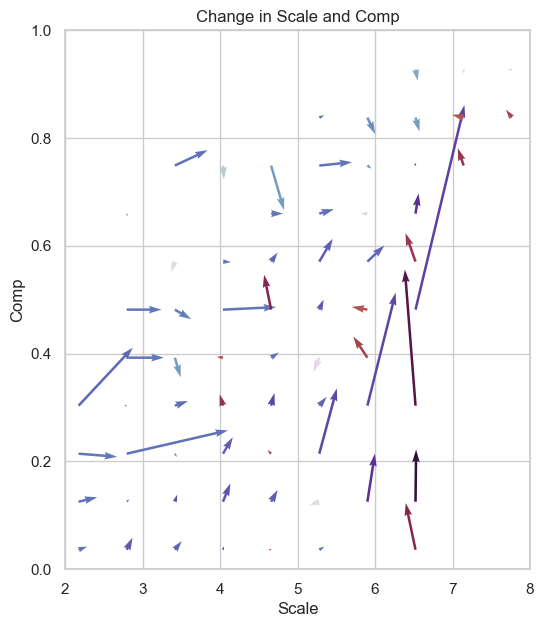

In [25]:
import seaborn as sns


# create vector plot
fig, ax = plt.subplots(figsize=(6, 7))
pink_r = plt.cm.get_cmap('pink_r')
# sns.histplot(x = dr.Scale_1, y = dr.Comp, bins=15, cmap = pink_r, alpha = 0.5, cbar = True, ax = ax)
u = np.clip(grid_1.values, -1, 1)
v = np.clip(grid_2.values, -0.1, 0.1)
u = grid_1.values
v = grid_2.values

std_1 = grid_1_std.values/grid_1.values
std_2 = grid_2_std.values/grid_2.values

std = np.sqrt(std_1**2 + std_2**2)
std = np.clip(std, 0, 20)
t_norm = np.reshape(std, -1)
t_scaled = (t_norm - t_norm[~np.isnan(t_norm)].min())/(t_norm[~np.isnan(t_norm)].max() - t_norm[~np.isnan(t_norm)].min())  # Normalize to 0-1

x, y = np.meshgrid(x_bins, y_bins)
# color arrows according to angle
color = np.arctan2(v, u)
color = plt.cm.twilight((color + np.pi/2) / (2*np.pi))  # Normalize and convert to RGBA

ax.quiver(x, y, u, v, scale_units='xy', angles='xy',
           color=color.reshape(-1, 4),
           alpha=1,  scale=1.1)
ax.set_xlim(2, 8)
ax.set_ylim(0,1.)
ax.set_ylabel('Comp')
ax.set_xlabel('Scale')
plt.title('Change in Scale and Comp')
plt.show()

C:\Users\matil\AppData\Local\Temp\ipykernel_25364\1355743016.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pink_r = plt.cm.get_cmap('pink_r')
C:\Users\matil\AppData\Local\Temp\ipykernel_25364\1355743016.py:50: RuntimeWarning: invalid value encountered in divide
  std_1 = grid_1_std.values/grid_1.values
C:\Users\matil\AppData\Local\Temp\ipykernel_25364\1355743016.py:51: RuntimeWarning: invalid value encountered in divide
  std_2 = grid_2_std.values/grid_2.values


ValueError: Argument U has a size 110 which does not match 121, the number of arrow positions

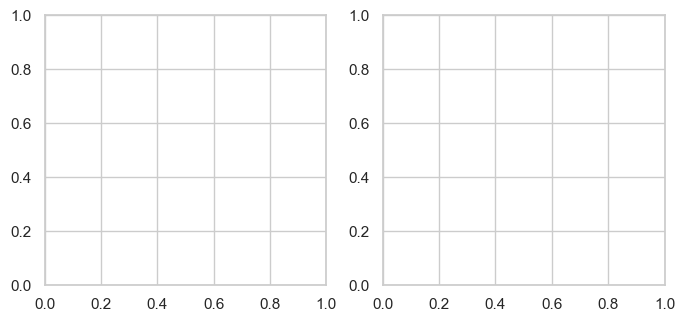

In [26]:
import seaborn as sns

cav = [0, 1, 2]

colors = ['firebrick', 'steelblue', 'darkorange']

fig, ax = plt.subplots(1,2,figsize=(8, 3.5))
cav = [0,1]
# plt.minorticks_on()
for n,c in enumerate(cav):
    Xy = dr.loc[(dr.Cavalry == c)]
    x = Xy["Scale_1"].values
    y = Xy["Comp"].values
    z1 = Xy["d_Scale"].values
    z2 = Xy["d_Comp"].values

    grid_size = 11

    df = pd.DataFrame({'x': x, 'y': y, 'z1': z1, 'z2': z2}) 

    # Define the grid
    x_bins = np.linspace(min(x), max(x), grid_size + 1)
    y_bins = np.linspace(min(y), max(y), grid_size + 1)

    # Bin the data
    df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)
    df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)


    x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
    y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

    # Group by the bins and calculate the mean of z
    grid_1 = df.groupby(['y_bin', 'x_bin'])['z1'].mean().unstack()
    grid_1_std = df.groupby(['y_bin', 'x_bin'])['z1'].std().unstack()
    counts_1 = df.groupby(['y_bin', 'x_bin'])['z1'].count().unstack()

    grid_2 = df.groupby(['y_bin', 'x_bin'])['z2'].mean().unstack()
    grid_2_std = df.groupby(['y_bin', 'x_bin'])['z2'].std().unstack()
    counts_2 = df.groupby(['y_bin', 'x_bin'])['z2'].count().unstack()

    # create vector plot
    pink_r = plt.cm.get_cmap('pink_r')
    # sns.histplot(x = dr.Scale_1, y = dr.Comp, bins=15, cmap = pink_r, alpha = 0.5, cbar = True, ax = ax)
    u = np.clip(grid_1.values, -1, 1)
    v = np.clip(grid_2.values, -0.1, 0.1)
    u = grid_1.values
    v = grid_2.values

    std_1 = grid_1_std.values/grid_1.values
    std_2 = grid_2_std.values/grid_2.values

    std = np.sqrt(std_1**2 + std_2**2)
    std = np.clip(std, 0, 20)
    t_norm = np.reshape(std, -1)
    t_scaled = (t_norm - t_norm[~np.isnan(t_norm)].min())/(t_norm[~np.isnan(t_norm)].max() - t_norm[~np.isnan(t_norm)].min())  # Normalize to 0-1

    x, y = np.meshgrid(x_bins, y_bins)
    # color arrows according to angle
    color = np.arctan2(v, u)
    color = plt.cm.twilight((color + np.pi/2) / (2*np.pi))  # Normalize and convert to RGBA

    ax[n].quiver(x, y, u, v, scale_units='xy', angles='xy',
            color=color.reshape(-1, 4),
            alpha=1.,  scale=1.1)
    ax[n].set_xlim(1, 8)
    ax[n].set_ylim(0, 1.)
    ax[0].set_ylabel('Comp')
    ax[n].set_title(f'Cavalry: {c}')
    ax[n].grid(True,  alpha=0.5)
    
    ax[n].set_xlabel('Scale')
plt.suptitle('Change in Scale and Comp')
plt.tight_layout()
plt.show()

In [ ]:
changes = pd.DataFrame(columns = ['NGA', 'PolityName', 'Scale', 'Comp', 'd_Scale', 'd_Comp'])

scv_imp_nga = dataset.scv_imputed.groupby('NGA')
for nga, group in scv_imp_nga:
    group = group.sort_values(['Year', 'PolityID'])

    pol_nga = group.groupby('PolityID')
    polities = pol_nga['PolityName'].first()
    scales = pol_nga['Scale_1'].apply(np.mean)
    comps = pol_nga['Comp'].apply(np.mean)
    years = pol_nga['Year'].apply(np.mean)

    d_year = (years.shift(-1)-years)/100
    d_scales = (scales.shift(-1)-scales)/d_year
    d_comps = (comps.shift(-1) - comps)/d_year

    df_temp = pd.DataFrame({'NGA': nga, 'PolityName':polities, 'Scale': scales, 'Comp': comps, 'd_Scale': d_scales, 'd_Comp': d_comps})
    changes = changes.append(df_temp)
changes.dropna(subset = ['d_Scale', 'd_Comp'], inplace = True)

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_52001/354031872.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  changes = changes.append(df_temp)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_52001/354031872.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  changes = changes.append(df_temp)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_52001/354031872.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  changes = changes.append(df_temp)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_52001/354031872.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  changes = changes.append(df_te

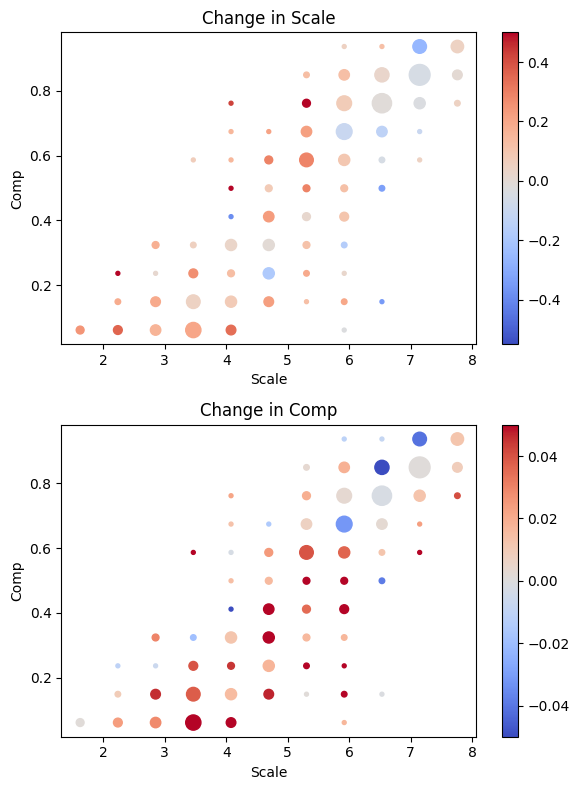

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(6, 8))

Xy = changes

x = Xy["Scale"].values
y = Xy["Comp"].values
z1 = Xy["d_Scale"].values
z2 = Xy["d_Comp"].values

grid_size = 11

df = pd.DataFrame({'x': x, 'y': y, 'z1': z1, 'z2': z2}) 

# Define the grid
x_bins = np.linspace(min(x), max(x), grid_size + 1)
y_bins = np.linspace(min(y), max(y), grid_size + 1)

# Bin the data
df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)
df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)


x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

# Group by the bins and calculate the mean of z
grid_1 = df.groupby(['y_bin', 'x_bin'])['z1'].mean().unstack()
grid_1_std = df.groupby(['y_bin', 'x_bin'])['z1'].std().unstack()
counts_1 = df.groupby(['y_bin', 'x_bin'])['z1'].count().unstack()

grid_2 = df.groupby(['y_bin', 'x_bin'])['z2'].mean().unstack()
grid_2_std = df.groupby(['y_bin', 'x_bin'])['z2'].std().unstack()
counts_2 = df.groupby(['y_bin', 'x_bin'])['z2'].count().unstack()

# remove entries in grid that are not statistically significant
# grid_1[grid_1_std > np.abs(grid_1)] = np.nan
# grid_2[grid_2_std > np.abs(grid_2)] = np.nan

# -------------------------------- AXIS 1 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[0].scatter(x.flatten(), y.flatten(), c=grid_1.values.flatten(), cmap='coolwarm', s=counts_1.values.flatten()*8, vmax = -0.5, vmin = 0.5)
cbar = plt.colorbar(ax[0].collections[0], ax=ax[0])
ax[0].set_title('Change in Scale')
ax[0].set_ylabel('Comp')
ax[0].set_xlabel('Scale')

# -------------------------------- AXIS 2 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[1].scatter(x.flatten(), y.flatten(), c=grid_2.values.flatten(), cmap='coolwarm', s=counts_2.values.flatten()*8, vmax = 0.05, vmin = -0.05)
cbar = plt.colorbar(ax[1].collections[0], ax=ax[1])
ax[1].set_title('Change in Comp')
ax[1].set_ylabel('Comp')
ax[1].set_xlabel('Scale')

plt.tight_layout()
plt.show()

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_52001/1507440410.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pink_r = plt.cm.get_cmap('pink_r')


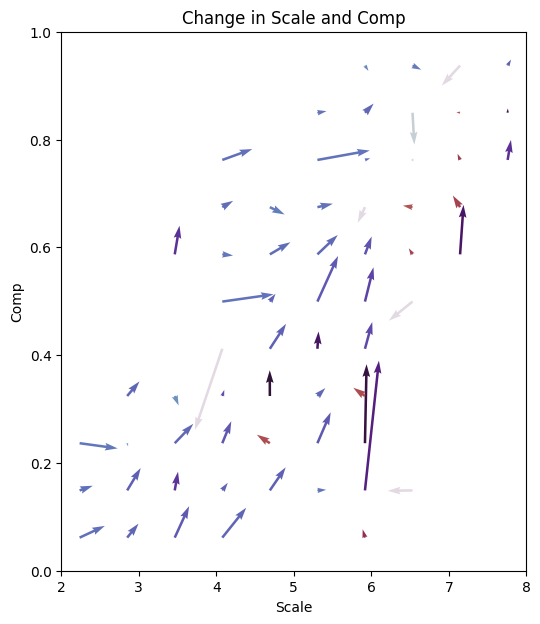

In [ ]:
import seaborn as sns
# create vector plot
fig, ax = plt.subplots(figsize=(6, 7))
pink_r = plt.cm.get_cmap('pink_r')
# sns.histplot(x = dr.Scale_1, y = dr.Comp, bins=15, cmap = pink_r, alpha = 0.5, cbar = True, ax = ax)
u = np.clip(grid_1.values, -1, 2)
v = np.clip(grid_2.values, -0.1, 0.2)
u = grid_1.values
v = grid_2.values

std_1 = grid_1_std.values/grid_1.values
std_2 = grid_2_std.values/grid_2.values

std = np.sqrt(std_1**2 + std_2**2)
std = np.clip(std, 0, 20)
t_norm = np.reshape(std, -1)
t_scaled = (t_norm - t_norm[~np.isnan(t_norm)].min())/(t_norm[~np.isnan(t_norm)].max() - t_norm[~np.isnan(t_norm)].min())  # Normalize to 0-1

x, y = np.meshgrid(x_bins, y_bins)
# color arrows according to angle
color = np.arctan2(v, u)
color = plt.cm.twilight((color + np.pi/2) / (2*np.pi))  # Normalize and convert to RGBA

ax.quiver(x, y, u, v, scale_units='xy', angles='xy',
           color=color.reshape(-1, 4),
           alpha=1,  scale=1.1)
ax.set_xlim(2, 8)
ax.set_ylim(0,1.)
ax.set_ylabel('Comp')
ax.set_xlabel('Scale')
plt.title('Change in Scale and Comp')
plt.show()